Reference:
    
    [1] mem640Lecture-Estimation.pdf

In [149]:
import numpy as np
import matplotlib.pyplot as plt

In [150]:
t    = np.arange(1,20)
#y    = np.array([8.49, 20.05, 50.65, 72.19, 129.85, 171.56])
g_theory = 9.8
mu, sigma = 0, 10 # mean and standard deviation
s = np.random.normal(mu, sigma, len(t))
y    = g_theory * (t * t)/2 + s

In [151]:
print(t)
print(y)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[-1.55152832e+00  2.67328808e+01  4.20455448e+01  7.97217349e+01
  1.41479223e+02  1.58338290e+02  2.40299986e+02  3.21889934e+02
  4.15722429e+02  5.07779270e+02  5.92138242e+02  6.95983246e+02
  8.27238153e+02  9.80091485e+02  1.11041983e+03  1.24927690e+03
  1.40662918e+03  1.58940409e+03  1.75661053e+03]


# The first approach: naive averaging

One approach: Calculate acceleration for each time instant and take average

In [152]:
g = 2 * y / (t * t)
g_mean = np.mean(g)

In [153]:
print(g, g_mean)

[-3.10305664 13.36644039  9.34345441  9.96521686 11.31833788  8.79657165
  9.80816268 10.05906042 10.26475132 10.1555854   9.78740896  9.66643397
  9.78980063 10.00093352  9.87039849  9.75997579  9.73445802  9.81113634
  9.73191427] 9.37510444065773


# The second approach – recast as a least squares problem

As shown below, Least squares estimate of gravitational constant is quite good.


In [154]:
phi = t * t / 2
print(phi.shape)
phi = np.reshape(phi, (len(phi),1))
print(phi.shape)
print(phi.T)


(19,)
(19, 1)
[[  0.5   2.    4.5   8.   12.5  18.   24.5  32.   40.5  50.   60.5  72.
   84.5  98.  112.5 128.  144.5 162.  180.5]]


In [155]:
phi_cov = phi.T @ phi
print(phi_cov.shape)
print(phi_cov)

(1, 1)
[[140666.5]]


In [156]:
g_esti2 = (1/phi_cov) @ phi.T @ y
print(g_esti2)

[9.79932534]


# An extension to free falling body problem.

Assuming y = a2 \* x^2 + a1 \* x + a0

With measurment result y, estimate A = {a2, a1, a0}


In [157]:
a2    = 1.52
a1    = 2.33
a0    = 7.49

x    = np.arange(1,20)
mu, sigma = 0, 1.01 # mean and standard deviation
s = np.random.normal(mu, sigma, len(t))
y    = a2 * (x * x) + a1 * x + a0 + s

[ 11.41110068  18.0224654   27.52997289  41.31101831  57.65439053
  75.82162263  98.58661748 123.37392541 152.26897649 184.38461825
 219.60702757 254.4979823  292.64585195 340.2858461  383.96821287
 432.41924846 486.69678031 543.42885136 599.9152754 ]


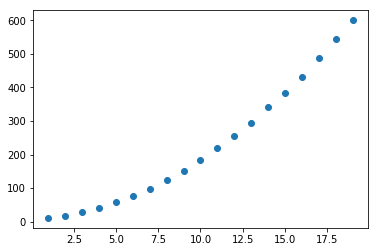

In [158]:
print(y)
plt.scatter(x,y)
plt.show()

In [159]:
#print(x)
phi_col0 = np.reshape((x*x).T, (len(x), 1))
phi_col1 = np.reshape(x.T, (len(x), 1))
phi_col2 = np.ones((len(x), 1))
phi = np.concatenate( ( phi_col0, phi_col1, phi_col2 ), axis = 1)
#print(phi_col0)
print(phi.shape)

phi_cov = phi.T @ phi
phi_cov_inv = np.linalg.inv(phi_cov)
print(phi_cov.shape, phi_cov_inv.shape, (phi.T).shape, y.shape)

para_esti = (phi_cov_inv) @ phi.T @ np.reshape(y,(len(y),1))

print(para_esti)

(19, 3)
(3, 3) (3, 3) (3, 19) (19,)
[[1.5103618 ]
 [2.53275625]
 [6.9480239 ]]


In [160]:
#print(phi)
print(phi_cov)
print(phi_cov_inv)
print(phi_cov_inv @ phi_cov)

[[5.62666e+05 3.61000e+04 2.47000e+03]
 [3.61000e+04 2.47000e+03 1.90000e+02]
 [2.47000e+03 1.90000e+02 1.90000e+01]]
[[ 7.37136960e-05 -1.47427392e-03  5.15995872e-03]
 [-1.47427392e-03  3.12398644e-02 -1.20743034e-01]
 [ 5.15995872e-03 -1.20743034e-01  5.89267286e-01]]
[[ 1.00000000e+00 -1.04083409e-17  1.56125113e-17]
 [-6.30051566e-15  1.00000000e+00 -4.85722573e-16]
 [-5.96189764e-13  1.75415238e-14  1.00000000e+00]]


# The third approach -- use recursion to update 

Least squares looks very good – but consider the following:

Q1. What if all data is not immediately available?

Q2. What if the sensor is noisy?

Q3. What if the state model is questionable?

以下仍然先回到自由落体运动问题。。。

In [168]:
t    = np.arange(1,20)
#y    = np.array([8.49, 20.05, 50.65, 72.19, 129.85, 171.56])
g_theory = 9.8
mu, sigma = 0, 10 # mean and standard deviation
s = np.random.normal(mu, sigma, len(t))
y    = g_theory * (t * t)/2 + s

phi = t * t / 2
K   = np.zeros((len(t),))
P   = np.zeros((len(t),))
g   = np.zeros((len(t),))
err = np.zeros((len(t),))
g[0] = y[1]
P[0] = 1

待估计参数以迭代的方式基于估计误差逐步更新，K表示更新时所使用的权重参数

看起来与LMS有点类似，但是更新公式确实是有所不同。那究竟有什么实质性的差异呢？

Seems to be RLS -- Recursive Least Squares

Actually it is Recursive Least Square, with M = 1, and lambda = 1. 因为M = 1, 所以所有的矩阵运算都退化为标量运算了。

In [170]:
for j in range(0, len(t)-1):    
    K[j+1]   = P[j] * phi[j+1] / (1 + phi.T[j+1] * P[j] * phi[j+1] )
    
    err[j+1] = (y[j+1] - phi[j+1] * g[j])
    
    g[j+1] = g[j] + K[j+1] * err[j+1]
    
    P[j+1] = (1 - K[j+1]*phi.T[j+1]) * P[j]
    

In [171]:
#print(phi)
print(K)
print(g)
print(P)

[0.         0.4        0.17821782 0.08963585 0.0509165  0.03160667
 0.02094465 0.01458689 0.01056338 0.00789391 0.00605348 0.00474363
 0.0037861  0.00306993 0.00252362 0.00209964 0.00176558 0.00149879
 0.00128317]
[10.61863491  6.37118095 10.49156114  9.11892501 10.18700447  9.97518666
  9.29369302  9.69633487  9.77614921  9.80928929  9.91234421  9.93153515
  9.87965901  9.85282964  9.85767704  9.82246991  9.82571475  9.81819461
  9.8246718 ]
[1.00000000e+00 2.00000000e-01 3.96039604e-02 1.12044818e-02
 4.07331976e-03 1.75592625e-03 8.54883522e-04 4.55840456e-04
 2.60824204e-04 1.57878118e-04 1.00057533e-04 6.58837481e-05
 4.48058785e-05 3.13258673e-05 2.24322127e-05 1.64034595e-05
 1.22185159e-05 9.25180642e-06 7.10897526e-06]


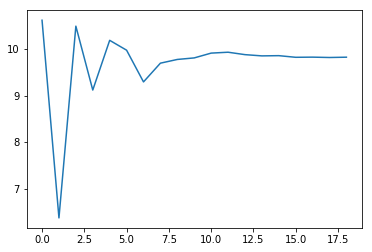

In [173]:
plt.plot(g)
plt.show()